# 🌍 ESG & 💲Financial Intelligence Platform
## AI-Powered Analysis of Corporate Reports (ESG And Annual)

**🎯 What this does:**
- Automatically processes PDF reports from Google Cloud Storage
- Uses Gemini 2.5 Pro to extract financial & ESG metrics
- Generates forecasts using Google's TimesFM 2.0 model
- Analyzes companies: Amgen, Novartis, Target

**📊 Features:**
- ✅ Automated PDF processing from Cloud Storage
- ✅ AI-powered data extraction (Financial + ESG metrics)
- ✅ Revenue forecasting with TimesFM 2.0
- ✅ Multi-company comparative analysis



# 🔑Setup & Authentication

In [12]:

print("🌟 Welcome to the ESG & Financial Intelligence Platform!")
print("🔧 Setting up environment...")

# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Install required packages
!pip install -q bigframes google-cloud-bigquery plotly seaborn

# Import libraries
import bigframes.pandas as bpd
from google.cloud import bigquery
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

print("✅ Authentication complete!")
print("✅ Libraries installed!")

🌟 Welcome to the ESG & Financial Intelligence Platform!
🔧 Setting up environment...
✅ Authentication complete!
✅ Libraries installed!


# 🚀 Intializing Parameters

In [13]:
# Replace the below with other company names from this list:
# novartis, amgen, target, bankofmontreal, lloyd, wellsfargo

company1 = "bankofmontreal"
company2 ="wellsfargo"
company3 = "jpmorganchase"

DATA_FILES_PATH="gs://report_insights"

PROJECT_ID = "intellitrend-project-dev"   # update if needed
PROJECT_LOCATION="US" # Others are EU, ASIA
CLOUD_RES_CONN = "ghack_conn" #must be all small case


DATASET_ID = "db_reports_insights_annual_esg" #Name of dataset to be created in BQ
OBJ_TABLE_ID = "all_reports_obj_table_metadata" #Objec table name. That holds the metadata of the source files in GCS
RAW_TABLE_ID="all_reports_ai_text_raw"   # the output text that gets extracted based on prmpt - using ML.GENERATE_TEXT

CURATED_TABLE_ID="all_reports_ai_text_curated" # response_text extracted from JSON output
CURATED2_TABLE_ID="all_reports_ai_text_curated2" # the output text that gets extracted based on prmpt - using AI.GENERATE (An alternate way - for comparison)

FINAL_TABLE_ID="all_reports_ai_text_final" # output metrics info from the curated table - using AI.GENERATE_TABLE

METRICS_TABLE_ID = "all_reports_metrics"  # format the output final table
FORECAST_TABLE_ID="all_reports_forecast" # forecast table from the formatted-output

QUALIFIED_CLOUD_RES_CONN = f"{PROJECT_ID}.{PROJECT_LOCATION}.{CLOUD_RES_CONN}"

QUALIFIED_OBJ_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{OBJ_TABLE_ID}"
QUALIFIED_RAW_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{RAW_TABLE_ID}"

QUALIFIED_CURATED_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED_TABLE_ID}"
QUALIFIED_CURATED2_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED2_TABLE_ID}"

QUALIFIED_METRICS_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{METRICS_TABLE_ID}"

QUALIFIED_FINAL_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FINAL_TABLE_ID}"
QUALIFIED_FORECAST_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FORECAST_TABLE_ID}"

MODEL_ENDPOINT="gemini-2.5-pro"
MODEL_NAME="gemini_model_25pro"
QUALIFIED_MODEL_ID=f"{PROJECT_ID}.{DATASET_ID}.{MODEL_NAME}"




# --- Bigframes setup ---
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# 🏗️ Project Configuration

In [3]:

from google.colab import userdata

# Configure BigFrames
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)

print(f"✅ Project configured: {PROJECT_ID}")
print("✅ BigFrames ready for action!")

✅ Project configured: intellitrend-project-dev
✅ BigFrames ready for action!


# 🔗Create Cloud Resource Connection

In [27]:
!bq mk \
  --connection \
  --project_id={PROJECT_ID} \
  --connection_type=CLOUD_RESOURCE \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN}

BigQuery error in mk operation: Already Exists: Connection
projects/573553606303/locations/us/connections/ghack_conn


# 🆔Fetch Service Account associated with the Cloud Res Connection

In [28]:
SERVICE_ACCT = !bq show --format=prettyjson \
  --connection \
  --project_id={PROJECT_ID} \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN} | grep "serviceAccountId" | cut -d '"' -f 4

SERVICE_ACCT_EMAIL = SERVICE_ACCT[0]  # first (and only) line
print(SERVICE_ACCT_EMAIL)

bqcx-573553606303-2s0n@gcp-sa-bigquery-condel.iam.gserviceaccount.com


# 👥Give the below roles to the Conn Service Account:
  * objectViewer and  
  * aiplatformUser



In [29]:
import time

# Use $SERVICE_ACCT_EMAIL so the Python variable expands in the shell
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/storage.objectViewer" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/aiplatform.user" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/bigquery.connectionUser" \
    --format=none


!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/run.invoker" \
    --format=none


# Wait ~60 seconds for IAM updates to propagate
# time.sleep(60)

Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].


#✦ Create the Gemini Model

In [30]:
# 🤖 Step 0a: Create Gemini 2.5 Pro Model
print("🤖 Creating Gemini 2.5 Pro model...")

create_model_sql = f"""
CREATE OR REPLACE MODEL `{QUALIFIED_MODEL_ID}`
REMOTE WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (ENDPOINT = '{MODEL_ENDPOINT}');
"""

try:
    job = client.query(create_model_sql)
    job.result()
    print("🎉 Gemini 2.5 Pro model created successfully!")
except Exception as e:
    print(f"⚠️  Model creation issue: {e}")

🤖 Creating Gemini 2.5 Pro model...
🎉 Gemini 2.5 Pro model created successfully!


# 𝄜 Create **Object Table** for PDF Reports

In [14]:
print(f"📁 Creating external table(Object Table): '{OBJ_TABLE_ID}' for PDF reports...")

create_external_table_sql = f"""
CREATE OR REPLACE EXTERNAL TABLE `{QUALIFIED_OBJ_TABLE_ID}`
WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['{DATA_FILES_PATH}/*']
);
"""

try:
    job = client.query(create_external_table_sql)
    job.result()
    print("✅ External table created successfully!")

    # Check what files we have
    check_files_sql = f"SELECT uri, size FROM `{QUALIFIED_OBJ_TABLE_ID}`  "
    files_df = bpd.read_gbq(check_files_sql)
    print(f"📄 Found {len(files_df)} files in storage")
    print("Sample files:")
    print(files_df.head())


except Exception as e:
    print(f"⚠️  Note: {e}")
    print("   Make sure your GCS bucket and connection are set up correctly")



📁 Creating external table(Object Table): 'all_reports_obj_table_metadata' for PDF reports...
✅ External table created successfully!
📄 Found 10 files in storage
Sample files:


                                                 uri      size
0  gs://report_insights/bankofmontreal/bankofmont...  14976908
1  gs://report_insights/bankofmontreal/bankofmont...   4240519
2  gs://report_insights/bankofmontreal/bankofmont...   4537673
3  gs://report_insights/bankofmontreal/bankofmont...   4552302
4  gs://report_insights/bankofmontreal/bankofmont...   3451258

[5 rows x 2 columns]


In [53]:

# print(f"֎ Processing PDFs with {MODEL_NAME}...")
# print(f"This analyzes {company1}, {company2}, and {company3} reports...")

# generate_text_sql = f"""
# CREATE OR REPLACE TABLE `{QUALIFIED_RAW_TABLE_ID}` AS (
# SELECT
#   *
# FROM
#   ML.GENERATE_TEXT(
#     MODEL `{QUALIFIED_MODEL_ID}`,
#     TABLE `{QUALIFIED_OBJ_TABLE_ID}`,
#     STRUCT(
#       '''
# You are an expert ESG and Financial analyst.

# Task:
# - Carefully analyze the provided PDF content.
# - Extract **only factual information present in the document**.
# - Prioritize **tables, charts, KPIs, financial metrics, ESG disclosures, and governance details**.
# - For multi-column pages or repeated headers/footers, ignore duplicates and focus on clean content.
# - If the document is very large, process it section by section and summarize clearly.
# - For tables and images, represent the data in structured text form whenever possible.

# Output:
# - Use clear, structured prose with labeled sections (Financial Metrics, ESG Metrics, Risk Disclosures, Governance, etc.).
# - Provide tabular data as markdown-style tables.
# - Do not invent or assume information not present in the PDF.
# - Ignore what data you cannot fetch and move next.
#       ''' AS prompt,

#       0 AS temperature,
#       8092 AS max_output_tokens
#     )
#   )
# WHERE uri like '%{company1}%' or uri like '%{company2}%' or  uri like '%{company3}%'
# );
# """
# #print("\n\n the SQL \n\n", generate_text_sql)
# try:
#     print("⏳ Processing... This may take 5-6 minutes")
#     job = client.query(generate_text_sql)
#     job.result()

#     # Check results
#     check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_RAW_TABLE_ID}`"
#     result = client.query(check_sql).result()
#     count = list(result)[0][0]
#     print(f"✅ Successfully processed {count} files!")

# except Exception as e:
#     print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes bankofmontreal, none, and none reports...
⏳ Processing... This may take 5-6 minutes
✅ Successfully processed 10 files!


#  ֎ Extract Financial & ESG Data - Using ML.GENERATE_TEXT

In [55]:

print(f"֎ Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_RAW_TABLE_ID}` AS (
SELECT
  *
FROM
  ML.GENERATE_TEXT(
    MODEL `{QUALIFIED_MODEL_ID}`,
    TABLE `{QUALIFIED_OBJ_TABLE_ID}`,
    STRUCT(
      '''
        You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.
        Fetch Financial and Sustainability Details including tabular and image data for each PDF.
        Read the filename. If it is a sustainability report, please get only ESG details. If it is an annual report, get just the financials as below.
        Ensure you fetch details so it has answers for:
        Financial Performance
        What is the total revenue this year?
        How has revenue changed compared to last year?
        What is the net profit or loss?
        How have the earnings per share (EPS) changed?
        Are gross margins improving or declining?
        Are operating margins stable or volatile?
        How has net margin shifted year over year?
        Is cash flow from operations positive and consistent?
        How much free cash flow is available?
        How are working capital levels trending?
        Balance Sheet & Liquidity
        What is the total debt level?
        Is the debt-to-equity ratio rising or falling?
        Does the company have enough liquidity to cover short-term liabilities?
        What is the current ratio and quick ratio?
        How much cash and equivalents are available?
        Are interest expenses sustainable?
        How sensitive is the company to interest rate changes?
        What is the level of contingent liabilities?
        Business Strategy
        What are the company’s core growth initiatives?
        Is management investing in new markets or products?
        How much is spent on research and development (R&D)?
        Are acquisitions or divestitures planned?
        Is the company expanding geographically?
        What is the company’s competitive advantage?
        Is the advantage sustainable against competitors?
        Is digital transformation a core part of the strategy?
        Risk Factors
        What macroeconomic risks affect the business?
        What industry-specific risks are highlighted?
        What operational risks are disclosed?
        Are supply chain risks material?
        Are legal or regulatory risks mentioned?
        How is foreign exchange risk managed?
        How dependent is revenue on a few customers?
        Are raw material price risks significant?
        Governance & Leadership
        Is the board majority independent?
        How many women or minorities are on the board?
        Is executive compensation performance-linked?
        Does management own significant equity?
        Are shareholder rights well protected?
        Is succession planning disclosed?
        Has management delivered on past promises?
        Is the auditor independent and credible?
        Shareholder Value
        Is the company paying dividends?
        Is the dividend payout sustainable?
        Is the dividend policy clear?
        Are share buybacks taking place?
        Is return on equity (ROE) improving?
        Is return on assets (ROA) stable?
        Has shareholder equity grown consistently?
        What is the earnings guidance for next year?
        Investor Questions – Sustainability Reports
        Environmental
        What is the total Scope 1 emissions?
        What is the total Scope 2 emissions?
        What is the total Scope 3 emissions?
        Are science-based targets disclosed?
        Has the company committed to net-zero?
        What percentage of energy is renewable?
        Is energy efficiency improving year over year?
        What is the total water withdrawal?
        What is water recycled or reused?
        Is the company exposed to water stress?
        How much total waste is generated?
        How much waste is recycled or diverted from landfill?
        Are hazardous waste levels disclosed?
        How sustainable are raw material sourcing practices?
        Are biodiversity risks addressed?
        Social
        What is the total workforce size?
        What percentage of employees are women?
        What percentage of leadership roles are held by women?
        What is minority representation in the workforce?
        What is the employee turnover rate?
        How many workplace injuries occurred?
        What is the lost-time injury frequency rate?
        Are labor rights respected across the supply chain?
        Is child labor risk disclosed in supply chains?
        Are employee training hours increasing per year?
        Are wages above local living wage levels?
        Is there employee engagement survey data?
        What community development initiatives exist?
        What philanthropic contributions were made?
        Is there disclosure on data privacy and cybersecurity?
        Governance (ESG-specific)
        Is there a dedicated board ESG committee?
        How often does the board review ESG matters?
        Is ESG risk included in enterprise risk management?
        Is executive compensation tied to ESG goals?
        Are ESG targets linked to management incentives?
        Is ESG performance externally assured?
        Are ESG disclosures aligned with GRI or SASB?
        Does the company report under TCFD or ISSB?
        Is CDP reporting publicly available?
        Are stakeholder engagement practices disclosed?
        Risk & Opportunity
        What are the identified physical climate risks?
        What are the identified transition risks?
        Is there disclosure on carbon pricing exposure?
        How dependent is revenue on carbon-intensive activities?
        What sustainability-linked opportunities are identified?
        Are green products or services generating revenue?
        Is access to sustainable finance increasing?
        Are suppliers evaluated for ESG performance?
        Are ESG clauses included in supplier contracts?
        Is there disclosure on product lifecycle impacts?
      ''' AS prompt,

      0 AS temperature,
      8092 AS max_output_tokens
    )
  )
WHERE uri like '%{company1}%' or uri like '%{company2}%' or  uri like '%{company3}%'
);
"""
#print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... This may take 2-3 minutes")
    job = client.query(generate_text_sql)
    job.result()

    # Check results
    check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_RAW_TABLE_ID}`"
    result = client.query(check_sql).result()
    count = list(result)[0][0]
    print(f"✅ Successfully processed {count} files!")

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes bankofmontreal, none, and none reports...
⏳ Processing... This may take 2-3 minutes
✅ Successfully processed 10 files!


### *Alternate Method to ML.GENERATE_TEXT:*
# ֎Extract Financial & ESG Data - using AI.GENERATE

In [16]:

print(f"🧠 Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql2 = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED2_TABLE_ID}` AS
SELECT
  uri,
  AI.GENERATE(
    CONCAT(
 "You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.\n",
"Fetch Financial and Sustainability Details including tabular and image data for each PDF.\n",
"Ensure you fetch details so it has answers for the below: fetch as-it-is. Donot format",
"Read the filename. If its a sustainability report, please get only ESG details. And if its an annual report, get just the financials as below:",
"Financial Performance\n",
"What is the total revenue this year?\n",
"How has revenue changed compared to last year?\n",
"What is the net profit or loss?\n",
"How have the earnings per share (EPS) changed?\n",
"Are gross margins improving or declining?\n",
"Are operating margins stable or volatile?\n",
"How has net margin shifted year over year?\n",
"Is cash flow from operations positive and consistent?\n",
"How much free cash flow is available?\n",
"How are working capital levels trending?\n\n",

"Balance Sheet & Liquidity\n",
"What is the total debt level?\n",
"Is the debt-to-equity ratio rising or falling?\n",
"Does the company have enough liquidity to cover short-term liabilities?\n",
"What is the current ratio and quick ratio?\n",
"How much cash and equivalents are available?\n",
"Are interest expenses sustainable?\n",
"How sensitive is the company to interest rate changes?\n",
"What is the level of contingent liabilities?\n\n",

"Business Strategy\n",
"What are the company’s core growth initiatives?\n",
"Is management investing in new markets or products?\n",
"How much is spent on research and development (R&D)?\n",
"Are acquisitions or divestitures planned?\n",
"Is the company expanding geographically?\n",
"What is the company’s competitive advantage?\n",
"Is the advantage sustainable against competitors?\n",
"Is digital transformation a core part of the strategy?\n\n",

"Risk Factors\n",
"What macroeconomic risks affect the business?\n",
"What industry-specific risks are highlighted?\n",
"What operational risks are disclosed?\n",
"Are supply chain risks material?\n",
"Are legal or regulatory risks mentioned?\n",
"How is foreign exchange risk managed?\n",
"How dependent is revenue on a few customers?\n",
"Are raw material price risks significant?\n\n",

"Governance & Leadership\n",
"Is the board majority independent?\n",
"How many women or minorities are on the board?\n",
"Is executive compensation performance-linked?\n",
"Does management own significant equity?\n",
"Are shareholder rights well protected?\n",
"Is succession planning disclosed?\n",
"Has management delivered on past promises?\n",
"Is the auditor independent and credible?\n\n",

"Shareholder Value\n",
"Is the company paying dividends?\n",
"Is the dividend payout sustainable?\n",
"Is the dividend policy clear?\n",
"Are share buybacks taking place?\n",
"Is return on equity (ROE) improving?\n",
"Is return on assets (ROA) stable?\n",
"Has shareholder equity grown consistently?\n",
"What is the earnings guidance for next year?\n\n",

"Investor Questions – Sustainability Reports\n\n",

"Environmental\n",
"What is the total Scope 1 emissions?\n",
"What is the total Scope 2 emissions?\n",
"What is the total Scope 3 emissions?\n",
"Are science-based targets disclosed?\n",
"Has the company committed to net-zero?\n",
"What percentage of energy is renewable?\n",
"Is energy efficiency improving year over year?\n",
"What is the total water withdrawal?\n",
"What is water recycled or reused?\n",
"Is the company exposed to water stress?\n",
"How much total waste is generated?\n",
"How much waste is recycled or diverted from landfill?\n",
"Are hazardous waste levels disclosed?\n",
"How sustainable are raw material sourcing practices?\n",
"Are biodiversity risks addressed?\n\n",

"Social\n",
"What is the total workforce size?\n",
"What percentage of employees are women?\n",
"What percentage of leadership roles are held by women?\n",
"What is minority representation in the workforce?\n",
"What is the employee turnover rate?\n",
"How many workplace injuries occurred?\n",
"What is the lost-time injury frequency rate?\n",
"Are labor rights respected across the supply chain?\n",
"Is child labor risk disclosed in supply chains?\n",
"Are employee training hours increasing per year?\n",
"Are wages above local living wage levels?\n",
"Is there employee engagement survey data?\n",
"What community development initiatives exist?\n",
"What philanthropic contributions were made?\n",
"Is there disclosure on data privacy and cybersecurity?\n\n",

"Governance (ESG-specific)\n",
"Is there a dedicated board ESG committee?\n",
"How often does the board review ESG matters?\n",
"Is ESG risk included in enterprise risk management?\n",
"Is executive compensation tied to ESG goals?\n",
"Are ESG targets linked to management incentives?\n",
"Is ESG performance externally assured?\n",
"Are ESG disclosures aligned with GRI or SASB?\n",
"Does the company report under TCFD or ISSB?\n",
"Is CDP reporting publicly available?\n",
"Are stakeholder engagement practices disclosed?\n\n",

"Risk & Opportunity\n",
"What are the identified physical climate risks?\n",
"What are the identified transition risks?\n",
"Is there disclosure on carbon pricing exposure?\n",
"How dependent is revenue on carbon-intensive activities?\n",
"What sustainability-linked opportunities are identified?\n",
"Are green products or services generating revenue?\n",
"Is access to sustainable finance increasing?\n",
"Are suppliers evaluated for ESG performance?\n",
"Are ESG clauses included in supplier contracts?\n",
"Is there disclosure on product lifecycle impacts?\n"
      "Open and Read the PDF: "
    ),
    connection_id => '{QUALIFIED_CLOUD_RES_CONN}',
    endpoint => '{MODEL_ENDPOINT}',
    output_schema => 'uri STRING, response_text STRING'
  ).response_text AS response_text
FROM `{QUALIFIED_RAW_TABLE_ID}`
WHERE uri LIKE '%{company1}%' OR uri LIKE '%{company2}%' OR uri LIKE '%{company3}%';
"""

      # JSON_VALUE(
      #   OBJ.GET_ACCESS_URL(
      #     OBJ.MAKE_REF(uri, '{QUALIFIED_CLOUD_RES_CONN}'),
      #     'r'
      #   ),
      #   '$.access_urls.read_url'
      # )

# try:
#     print("⏳ Processing... This may take 2-3 minutes")
#     job = client.query(generate_text_sql2)
#     job.result()

#     # Check results
#     check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_CURATED2_TABLE_ID}`"
#     result = client.query(check_sql).result()
#     count = list(result)[0][0]
#     print(f"✅ Successfully processed {count} files!")

# except Exception as e:
#     print(f"⚠️  Processing issue: {e}")


🧠 Processing PDFs with gemini_model_25pro...
This analyzes novartis, wellsfargo, and unitedhealth reports...
⏳ Processing... This may take 2-3 minutes
✅ Successfully processed 32 files!


# 🧹 Extract Clean Text Response

In [56]:

print("🧹 Cleaning and extracting response text...")

curate_results_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED_TABLE_ID}` AS
SELECT *,
  ARRAY_TO_STRING(
    ARRAY(
      SELECT JSON_VALUE(part, '$.text')
      FROM UNNEST(JSON_QUERY_ARRAY(
        JSON_QUERY(ml_generate_text_result, '$.candidates[0].content.parts')
      )) AS part
    ),
    ''
  ) AS response_text
FROM
  `{QUALIFIED_RAW_TABLE_ID}`;
"""

try:
    job = client.query(curate_results_sql)
    job.result()
    print("✅ Response text extracted and cleaned!")

    # Show sample of extracted text
    sample_sql = f"""
    SELECT uri, LEFT(response_text, 200) as sample_text
    FROM `{QUALIFIED_CURATED_TABLE_ID}`
    LIMIT 3
    """
    sample_df = bpd.read_gbq(sample_sql)
    print("\n📝 Sample extracted text:")
    for _, row in sample_df.iterrows():
        print(f"File: {row['uri']}")
        print(f"Text: {row['sample_text']}...\n")

except Exception as e:
    print(f"⚠️  Text extraction issue: {e}")

🧹 Cleaning and extracting response text...
✅ Response text extracted and cleaned!

📝 Sample extracted text:
File: gs://report_insights/bankofmontreal/bankofmontreal_sustainabilityreport_2022.pdf
Text: Based on the BMO 2022 Sustainability Report, here are the financial and ESG details:

### **Financial Performance**

The report provides a high-level summary of financial performance in the context of...

File: gs://report_insights/bankofmontreal/bankofmontreal_annualreport_2021.pdf
Text: Here are the financial and sustainability details from BMO Financial Group's 2021 Annual Report.

### **Financial Performance**

| Metric | 2021 | 2020 | Change | Analysis |
| --- | --- | --- | --- | ...

File: gs://report_insights/bankofmontreal/bankofmontreal_sustainabilityreport_2021.pdf
Text: Here is a detailed analysis of BMO Financial Group's 2021 Sustainability Report, based on the provided document.

### **Financial Performance**

**Revenue and Profitability:**
*   **Total Revenue (202...



# 📊 Extract Structured Metrics - Using AI.GENERATE_TABLE

In [57]:

print("📊 Generating structured financial and ESG metrics...")

generate_table_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FINAL_TABLE_ID}` AS
SELECT *,
    DATE(CAST(fiscal_year AS STRING) || "-01-01") AS fiscal_year_date,
    CASE
        WHEN uri LIKE '%{company1}%' THEN '{company1}'
        WHEN uri LIKE '%{company2}%' THEN '{company2}'
        WHEN uri LIKE '%{company3}%' THEN '{company3}'
    END as company_name_formatted
FROM (
    SELECT *
    FROM AI.GENERATE_TABLE(
        MODEL `{QUALIFIED_MODEL_ID}`,
        (
            SELECT CONCAT(
                "You are an expert financial analyst and ESG/Climate analyst. Extract all financial metrics and sustainability metrics and KPIs from the provided text into structured data. ",
                "For Annual reports, focus on getting the financial metrics. And for Sustainability reports focus on getting ESG metrics. ",
                "Normalize numbers by removing commas, spaces, or symbols and convert all money values to dollars. ",
                "TEXT: ",
                response_text
            ) AS prompt,
            response_text as extracted_text,
            uri AS uri
        FROM `{QUALIFIED_CURATED_TABLE_ID}`
        ),
        STRUCT(
            'uris STRING, report_type STRING, company_name STRING, fiscal_year INT64, revenue_millions FLOAT64, net_income_millions FLOAT64, total_assets_millions FLOAT64, total_liabilities_millions FLOAT64, equity_millions FLOAT64, eps_basic FLOAT64, eps_diluted FLOAT64, dividends_per_share FLOAT64, employee_count INT64, business_segments ARRAY<STRING>, total_ghg_emissions FLOAT64, scope_1_ghg_emissions FLOAT64, scope_2_ghg_emissions FLOAT64, scope_3_ghg_emissions FLOAT64, carbon_intensity FLOAT64, energy_consumption FLOAT64, renewable_energy_usage FLOAT64, water_consumption FLOAT64, waste_generated FLOAT64, waste_recycled FLOAT64, sustainable_financing FLOAT64, reporting_period STRING, page_references ARRAY<STRING>, contexts ARRAY<STRING>, verbatim_quotes ARRAY<STRING>'
            AS output_schema,
            8192 AS max_output_tokens,
            0 AS temperature
        )
    ) t
);
"""

try:
    print("⏳ Structuring data... This may take 3-4 minutes")
    job = client.query(generate_table_sql)
    job.result()
    print("✅ Structured metrics extracted successfully!")

except Exception as e:
    print(f"⚠️  Table generation issue: {e}")

📊 Generating structured financial and ESG metrics...
⏳ Structuring data... This may take 3-4 minutes
✅ Structured metrics extracted successfully!


# Generate Metric Table
---



In [58]:

print("🔮 Generating metrics table")

metrics_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_METRICS_TABLE_ID}` AS
SELECT * FROM
    ( SELECT
        uri, fiscal_year,
        extracted_text, company_name_formatted as company_name,
        -- Determine report_type based on URI
        CASE
            WHEN LOWER(uri) LIKE '%annual%' THEN 'Annual'
            WHEN LOWER(uri) LIKE '%sustainability%' THEN 'Sustainability'
            ELSE 'Other'
        END AS report_type,
        fiscal_year_date,
        reporting_period ,
        -- Financial metrics: keep if Annual, else 0
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN revenue_millions ELSE 0 END AS revenue_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN net_income_millions ELSE 0 END AS net_income_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_assets_millions ELSE 0 END AS total_assets_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_liabilities_millions ELSE 0 END AS total_liabilities_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN equity_millions ELSE 0 END AS equity_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN dividends_per_share ELSE 0 END AS dividends_per_share,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_basic ELSE 0 END AS eps_basic,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_diluted ELSE 0 END AS eps_diluted,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN employee_count ELSE 0 END AS employee_count,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN sustainable_financing ELSE 0 END AS sustainable_financing,

        -- Sustainability metrics: keep if Sustainability report, else 0
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN carbon_intensity ELSE 0 END AS carbon_intensity,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN energy_consumption ELSE 0 END AS energy_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN renewable_energy_usage ELSE 0 END AS renewable_energy_usage,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_1_ghg_emissions ELSE 0 END AS scope_1_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_2_ghg_emissions ELSE 0 END AS scope_2_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_3_ghg_emissions ELSE 0 END AS scope_3_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN total_ghg_emissions ELSE 0 END AS total_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN water_consumption ELSE 0 END AS water_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_generated ELSE 0 END AS waste_generated,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_recycled ELSE 0 END AS waste_recycled

     FROM `{QUALIFIED_FINAL_TABLE_ID}`
     ) t
-- WHERE report_type != 'Annual';

"""

print("⏳ fetching metrics...")
job = client.query(metrics_sql)
job.result()
print("✅ Metrics table created successfully!")

🔮 Generating metrics table
⏳ fetching metrics...
✅ Metrics table created successfully!


# Output 1
### Financial/ESG Details for pre-defined questions for selected company and fiscal_year and report type

In [60]:
from IPython.display import display, Markdown


# --- Load your BigQuery table ---
#df = bpd.read_gbq(f"{QUALIFIED_METRICS_TABLE_ID}")
metrics_sql1 = f"""
SELECT *
FROM `{QUALIFIED_METRICS_TABLE_ID}`
"""
df = bpd.read_gbq(metrics_sql1)

# --- Choose which report to display ---
company = "bankofmontreal"
year = 2021
rtype = "Annual"   # "Annual" or "Sustainability Report"

# --- Filter ---
filtered = df[
    (df["company_name"] == company)
    & (df["fiscal_year"] == year)
    & (df["report_type"] == rtype)
]

# --- Display pretty ---
if not filtered.empty:
    text = filtered["extracted_text"].iloc[0]
    display(Markdown(text))
else:
    print("No report found for that selection.")


# --- Grab the first row (or loop if multiple) ---
text = df["extracted_text"].iloc[0]

# --- Pretty display in Colab ---
print("\n\n===========================================================================\n\n")
display(Markdown(text))

Here are the financial and sustainability details from BMO Financial Group's 2021 Annual Report.

### **Financial Performance**

| Metric | 2021 | 2020 | Change | Analysis |
| --- | --- | --- | --- | --- |
| **Total Revenue** | C$27,186 million | C$25,186 million | +7.9% | Revenue grew by C$2.0 billion, reflecting a recovery from the pandemic's impacts and growth across operating groups. |
| **Net Income** | C$7,754 million | C$5,097 million | +52.1% | Net income increased significantly, driven by lower provisions for credit losses and strong revenue growth. |
| **Diluted Earnings Per Share (EPS)** | $11.58 | $7.55 | +53.4% | EPS saw substantial growth, increasing by $4.03, primarily due to higher earnings. |
| **Net Interest Margin (NIM)** | 1.59% | 1.64% | -5 bps | The overall net interest margin decreased by 5 basis points, driven by higher liquidity levels and lower trading-related income, partially offset by higher margins in P&C businesses (Page 34). |
| **Efficiency Ratio (net of CCPB)** | 60.1% | 60.4% | -30 bps | The efficiency ratio, a measure of productivity, showed a slight improvement (a lower ratio is better), indicating effective expense management relative to revenue. |
| **Net Margin (Calculated)** | 28.5% | 20.2% | +8.3 p.p. | The net profit margin improved considerably year-over-year, reflecting the strong growth in net income. |
| **Cash Flow from Operations** | C$44,049 million | C$50,836 million | -13.3% | Cash flow from operations was positive and substantial but decreased from the prior year. The change was influenced by movements in deposits, loans, and trading securities. |
| **Free Cash Flow (Calculated)** | C$43,565 million | C$50,352 million | -13.5% | The company generated significant free cash flow (Operating Cash Flow less net purchases of premises and equipment), though less than the prior year. |

---
### **Balance Sheet & Liquidity**

| Metric | 2021 | 2020 | Analysis |
| --- | --- | --- | --- |
| **Total Debt (Subordinated)** | C$6,893 million | C$8,416 million | Subordinated debt decreased due to redemptions, net of a new issuance. Total liabilities stood at C$930.7 billion. |
| **Debt-to-Equity Ratio (Calculated)** | 16.18 | 15.77 | The ratio of total liabilities to total equity increased slightly, indicating a modest rise in leverage. |
| **Liquidity Coverage Ratio (LCR)** | 125% | 131% | The LCR remains well above the 100% regulatory minimum, indicating a strong liquidity position to cover short-term obligations, despite a decrease from 2020. |
| **Net Stable Funding Ratio (NSFR)** | 118% | N/A | The NSFR of 118% exceeds the 100% regulatory minimum, demonstrating a stable medium- and long-term funding profile. |
| **Cash and Equivalents** | C$93,261 million | C$57,408 million | Cash and cash equivalents increased significantly, driven by customer deposit growth in excess of loan growth. |
| **Interest Rate Sensitivity** | N/A | N/A | The company is sensitive to interest rate changes. A 100 basis point increase in rates would increase pre-tax net income by C$331.8 million over 12 months. A 25 basis point decrease would lower it by C$82.4 million (Page 97). |
| **Contingent Liabilities** | C$228,005 million | C$221,609 million | The maximum amount payable for commitments, including guarantees, letters of credit, and commitments to extend credit, was C$228.0 billion. |

---
### **Business Strategy**

*   **Core Growth Initiatives:** BMO's strategy is anchored in its purpose to "Boldly Grow the Good in business and life". Key strategic priorities include (Page 10):
    *   Achieving world-class client loyalty and growth.
    *   Fostering a winning culture driven by alignment and empowerment.
    *   Being "Digital First" for speed, efficiency, and scale.
    *   Simplifying work and eliminating complexity.
    *   Superior management of risk and capital performance.
*   **New Markets & Products:** The company is expanding its U.S. commercial banking presence nationally, opening new offices in cities like Atlanta, Fort Worth, and Los Angeles. It also launched new products such as the BMO eclipse Visa credit cards and the BMO Family Bundle™ to attract new customers (Pages 9, 42).
*   **Acquisitions & Divestitures:** In 2021, BMO completed the sale of its Private Banking business in Hong Kong and Singapore and its EMEA asset management business. It also entered an agreement to sell Taplin, Canida & Habacht, LLC. These moves are part of a strategy to reposition and grow operations in the core North American footprint (Page 183).
*   **Geographic Expansion:** The company is focused on growing its presence across the United States, with its U.S. operations being the fastest-growing segment. The U.S. footprint is now described as "the U.S.", moving beyond its historical Midwest focus (Page 10).
*   **Competitive Advantage:** BMO's key advantage is its integrated North American platform, being "the only bank that runs all of its operating groups on an integrated basis on both sides of the border, driving efficiencies, scale and speed to market" (Page 8). Its 204-year history and purpose-driven, "future-ready" bank model are also highlighted as differentiators.
*   **Digital Transformation:** "Digital First" is a core strategic pillar. The strategy is built for speed, efficiency, and scale, enabling personalized digital experiences for customers and driving loyalty and growth. The bank has made significant investments in its digital agenda to drive efficiency, increase speed to market, and enhance the customer experience (Pages 10, 14).

---
### **Risk Factors**

*   **Macroeconomic Risks:** The report highlights risks from the ongoing COVID-19 pandemic, disruptions to global supply chains, price and wage inflation, labor market challenges, and geopolitical tensions. It also notes risks related to the Canadian housing market, high household debt, and inflation (Pages 76, 78).
*   **Industry-Specific Risks:** The global transition away from Interbank Offered Rates (IBORs) to Alternative Reference Rates (ARRs) is a complex, industry-wide risk. The company has an enterprise IBOR Transition Office to manage this (Page 77).
*   **Operational Risks:** The company is exposed to risks from potential failures of internal processes, technology, and human error. Key operational risks highlighted include Cyber Security, Technology Disruption and Resiliency, and Third-Party Risk, which are elevated due to remote work and increased reliance on digital technologies (Page 109).
*   **Legal & Regulatory Risks:** The financial services industry is highly regulated. BMO faces risks from changes in laws and regulations, including consumer protection, privacy laws (e.g., CCPA), anti-money laundering (AML), and climate-related disclosure requirements. A specific tax dispute with Canadian authorities regarding "dividend rental arrangements" is also disclosed (Pages 111, 205).
*   **Foreign Exchange Risk:** BMO is exposed to translation risk from its net investment in U.S. operations and transaction risk from U.S. dollar-denominated income. The company may use hedging to manage these risks (Page 98).

---
### **Governance & Leadership**

*   **Board Independence:** The Audit and Conduct Review Committee is comprised entirely of independent directors. The 13-member board includes one executive director (the CEO), implying a strong majority of independent directors (Page 122).
*   **Board Diversity:** The board is gender-balanced, comprising six women and seven men (46% women). The company has also set a target to increase the representation of People of Color in U.S. senior leadership roles to 30% (Pages 5, 7).
*   **Executive Compensation:** Compensation is performance-linked. The report notes that "performance-based compensation increased... reflecting improved business performance" (Page 38).
*   **Management Equity Ownership:** Directors have a significant equity ownership requirement, needing to hold shares/units valued at eight times their annual retainer, aligning their interests with shareholders (Page 213).
*   **Shareholder Rights:** The company offers a Dividend Reinvestment and Share Purchase Plan (DRIP) and provides clear channels for shareholders to communicate with the board (Page 215).
*   **Succession Planning:** The Board of Directors and its committees are responsible for succession planning for senior management, including the CEO and CRO (Page 82).
*   **Auditor Independence:** The Audit and Conduct Review Committee oversees auditor independence, with a policy for lead partner rotation every five years. The auditor is KPMG LLP (Page 122).

---
### **Shareholder Value**

*   **Dividends:** BMO has the longest-running dividend payout record of any company in Canada, at 193 years. The dividend declared in 2021 was $4.24 per common share. A 25% dividend increase to $1.33 per share was announced for Q1 2022 (Pages 5, 74).
*   **Dividend Policy & Sustainability:** The target dividend payout ratio is 40% to 50% of net income. The 2021 adjusted payout ratio was 32.6%, indicating the dividend is sustainable with room for growth (Pages 26, 74).
*   **Share Buybacks:** The company announced a new Normal Course Issuer Bid (NCIB) to purchase up to 22.5 million common shares, starting in fiscal 2022. No shares were repurchased in 2021 due to regulatory restrictions that have since been lifted (Page 73).
*   **Return on Equity (ROE):** ROE is improving. Adjusted ROE was 16.7% in 2021, up from 10.3% in 2020, and exceeding the medium-term target of 15% or more (Page 26).
*   **Return on Assets (ROA):** ROA is stable and improving. Adjusted ROA was 0.88% in 2021, up from 0.55% in 2020 (Page 124).
*   **Shareholder Equity Growth:** Total equity grew from C$56.6 billion in 2020 to C$57.5 billion in 2021. Retained earnings grew by C$4.8 billion (Page 151).

---
### **Sustainability (ESG) Highlights**

*   **Net-Zero Commitment:** BMO has committed to achieving net-zero financed emissions by 2050 and aims to be its clients' lead partner in the transition. It has joined the Net-Zero Banking Alliance (Page 12).
*   **GHG Emissions & Targets:** The company has a target to reduce its operational GHG emissions by 30% by 2030 from a 2019 baseline. It has also matched 100% of its global electricity use with renewable electricity purchases since 2020 (Page 13).
*   **Sustainable Finance:** BMO has a 2025 goal of mobilizing C$300 billion in capital for clients pursuing sustainable outcomes. It has also launched a C$250 million Impact Investment Fund to back technologies that drive sustainable outcomes (Page 17).
*   **Social Commitments:**
    *   **BMO EMpower:** A US$5 billion, five-year commitment to address systemic barriers faced by minority businesses, communities, and families in the U.S. (Page 5).
    *   **Affordable Housing:** A C$12 billion commitment over 10 years to finance affordable housing in Canada (Page 5).
    *   **Indigenous Banking:** Committed to doubling its book of Indigenous business to C$8 billion by 2025, having already reached 80% of this goal (Page 17).
*   **Diversity & Inclusion:**
    *   **Women in Leadership:** For the last six years, more than 40% of senior leaders have been women (Page 17).
    *   **Racial Equity:** Set a target to increase the representation of People of Color in U.S. senior roles to 30% and has doubled its hiring of Indigenous staff in the past year (Pages 5, 17).
*   **ESG Governance & Reporting:** ESG is overseen at the board level by the Risk Review Committee and the Audit and Conduct Review Committee. The company's Sustainability Report is prepared in accordance with GRI, SASB, and TCFD frameworks (Pages 113, 115).

Here are the financial and sustainability details for BMO Financial Group, based on its 2022 Annual Report.

### **Financial Performance**

**What is the total revenue this year?**
The total revenue for 2022 was **$33,710 million**. On a basis that nets insurance claims, commissions, and changes in policy benefit liabilities (net of CCPB), the revenue was **$34,393 million** (Page 26, 144).

**How has revenue changed compared to last year?**
Reported revenue increased by 24% from $27,186 million in 2021. Revenue net of CCPB increased by 33% from $25,787 million in 2021 (Page 26, 29).

**What is the net profit or loss?**
The net income for 2022 was **$13,537 million**, a 75% increase from $7,754 million in 2021. Adjusted net income was $9,039 million, a 4% increase from $8,651 million in 2021 (Page 26, 34).

**How have the earnings per share (EPS) changed?**
Reported diluted EPS increased by 72.7% to **$19.99** in 2022 from $11.58 in 2021. Adjusted diluted EPS increased by 2.1% to **$13.23** from $12.96 in 2021 (Page 5, 26).

![EPS Growth Chart](https://i.imgur.com/2022/05/16/19/53/53/72.7/68.0/53.3/2.1/(12.8)/(18.2)/2020/2021/2022/image.png)

**Are gross margins improving or declining?**
As a bank, gross margin is not a standard metric. The equivalent is the **Net Interest Margin (NIM)**. The NIM on average earning assets was **1.62%** in 2022, up from 1.59% in 2021 (Page 26).

**Are operating margins stable or volatile?**
The bank's **Adjusted Efficiency Ratio (net of CCPB)**, a measure of productivity, slightly worsened to **55.8%** in 2022 from 56.5% in 2021, indicating relatively stable operating margins. The reported efficiency ratio improved significantly due to specific adjusting items (Page 24, 26).

**How has net margin shifted year over year?**
Net margin is not a standard metric for banks. However, Return on Equity (ROE) is a key profitability measure. Reported ROE increased to **22.9%** in 2022 from 14.9% in 2021. Adjusted ROE decreased to **15.2%** from 16.7% in 2021 (Page 5, 26).

**Is cash flow from operations positive and consistent?**
Yes, cash flow from operations was positive. Net cash provided by operating activities was **$4,957 million** in 2022, compared to $44,049 million in 2021. The significant variance is due to large changes in operating assets and liabilities, including trading securities and deposits (Page 148).

**How much free cash flow is available?**
Banks do not report free cash flow in the same way as industrial companies. After accounting for net cash used in investing activities (-$29,471 million) and net cash provided by financing activities ($15,980 million), the net decrease in cash and cash equivalents was $5,795 million (Page 148).

**How are working capital levels trending?**
Working capital is not a standard metric for banks. Liquidity is measured by the Liquidity Coverage Ratio (LCR) and Net Stable Funding Ratio (NSFR). The LCR improved to **135%** in 2022 from 125% in 2021. The NSFR decreased to **114%** from 118% in 2021, with both remaining above the 100% regulatory minimum (Page 26).

---
### **Balance Sheet & Liquidity**

**What is the total debt level?**
As a bank, its liabilities primarily consist of deposits and other debt instruments.
*   **Deposits:** $769,478 million
*   **Subordinated Debt:** $8,150 million
(Page 146)

**Is the debt-to-equity ratio rising or falling?**
The ratio of total liabilities to total equity was **15.04** in 2022 ($1,068,161M / $71,038M), down from 16.18 in 2021 ($930,652M / $57,523M), indicating a decrease in leverage (Page 146).

**Does the company have enough liquidity to cover short-term liabilities?**
Yes. The Liquidity Coverage Ratio (LCR) was **135%** for the quarter ended October 31, 2022, which is well above the regulatory minimum of 100%. This indicates the bank holds sufficient high-quality liquid assets to cover its total net stressed cash outflows over 30 days (Page 26, 103).

**What is the current ratio and quick ratio?**
These ratios are not standard for financial institutions. The LCR (135%) and Net Stable Funding Ratio (114%) are the relevant liquidity measures, and both are above regulatory requirements (Page 26).

**How much cash and equivalents are available?**
As of October 31, 2022, BMO had **$87,466 million** in cash and cash equivalents (Page 146).

**Are interest expenses sustainable?**
Yes. For 2022, Net Interest Income (the profit from lending and borrowing) was **$15,885 million** after accounting for $11,012 million in interest expenses, indicating that interest expenses are sustainably managed (Page 144).

**How sensitive is the company to interest rate changes?**
The company is sensitive to interest rate changes. As of October 31, 2022:
*   A 100 basis point parallel increase in interest rates would result in a **$498.9 million increase** in projected 12-month pre-tax net income.
*   A 100 basis point parallel decrease would result in a **$595.2 million decrease** in projected 12-month pre-tax net income.
(Page 96)

**What is the level of contingent liabilities?**
The maximum amount payable for off-balance sheet commitments, including commitments to extend credit, letters of credit, and financial guarantees, was **$263,688 million** as of October 31, 2022. The report notes that the total contractual amount is not representative of the actual funding likely to be required (Page 207).

---
### **Business Strategy**

**What are the company’s core growth initiatives?**
BMO's strategy is to build a "digitally enabled, future-ready bank with leading efficiency, profitability and loyalty." Core initiatives include driving growth through its strong North American franchise, enhancing the digital experience to drive customer acquisition and share of wallet, and simplifying operations to improve efficiency (Page 4, 43).

**Is management investing in new markets or products?**
Yes. The most significant investment is the planned acquisition of **Bank of the West**, which will substantially expand BMO's U.S. footprint, particularly in California. The company also launched new digital tools like BMO Global Money Transfer™ and enhanced its BMO NewStart® program for newcomers (Page 8, 12, 43).

**How much is spent on research and development (R&D)?**
Banks do not report R&D as a separate line item. Investment in technology and digital capabilities is the equivalent. The report highlights consistent recognition for its digital leadership, including being named the overall leader in The Forrester Digital Experience Review™ for Canadian Mobile Banking Apps (Page 6).

**Are acquisitions or divestitures planned?**
*   **Acquisition:** BMO announced the definitive agreement to acquire **Bank of the West** from BNP Paribas for a cash purchase price of US$16.3 billion. The acquisition is expected to close in the first calendar quarter of 2023 (Page 8, 31).
*   **Divestiture:** In 2022, BMO completed the sale of its EMEA Asset Management business to Ameriprise Financial (Page 31, 180).

**Is the company expanding geographically?**
Yes, significantly. The acquisition of Bank of the West will add nearly 1.8 million customers and over 500 branches, expanding BMO's presence into 32 U.S. states, including a major entry into the California market (Page 8, 31).

**What is the company’s competitive advantage?**
BMO's competitive advantages include its "diversified and advantaged business mix," its integrated North American presence across Canada and the U.S., a strong digital platform, and a long-standing history (205 years) and brand reputation (Page 2, 8).

**Is the advantage sustainable against competitors?**
Management believes its strategy is sustainable. The report states, "Our diversified business mix enables us to deliver resilient revenue performance through economic cycles." The acquisition of Bank of the West is intended to "deepen BMO's position as a leading North American bank" and solidify its U.S. franchise for long-term growth (Page 8).

**Is digital transformation a core part of the strategy?**
Yes, it is a central pillar. The strategy is to build a "digitally enabled, future-ready bank" and put "digital first." The company has received numerous awards for its mobile and online banking platforms and is focused on using technology to simplify banking and drive efficiency (Page 4, 6, 9).

---
### **Risk Factors**

**What macroeconomic risks affect the business?**
The primary macroeconomic risks include:
*   **General Economic Conditions:** Slowing GDP growth in Canada and the U.S.
*   **Inflation:** High inflation rates putting pressure on customers and operating costs.
*   **Interest Rates:** Aggressive monetary tightening by central banks increasing borrowing costs and the risk of recession.
*   **Geopolitical Risk:** The conflict in Ukraine and tensions between the U.S. and China.
(Page 32, 76)

**What industry-specific risks are highlighted?**
Industry-specific risks include intense competition from traditional and non-traditional players, evolving regulatory requirements, and the need to adapt to technological innovation and changing customer preferences (Page 46, 78-79).

**What operational risks are disclosed?**
Key operational risks include **cybersecurity and cloud security risk**, technology resiliency, data and analytics risks, third-party risk, and potential for fraud or process failures (Page 76, 107-108).

**Are supply chain risks material?**
Global supply-chain disruptions are mentioned as a headwind for the North American economy and a factor contributing to inflation, which indirectly affects the bank's operating environment and its customers (Page 8, 76).

**Are legal or regulatory risks mentioned?**
Yes. The company is subject to extensive regulation, and failure to comply can result in legal proceedings, sanctions, and reputational damage. Specific risks mentioned include changes to capital and liquidity requirements, consumer protection laws, privacy laws, and anti-money laundering (AML) regulations. A specific legal provision of $1,142 million (pre-tax) was recorded in 2022 related to a lawsuit involving a predecessor bank (Page 28, 78, 110).

**How is foreign exchange risk managed?**
The bank manages foreign exchange risk arising from its net investment in U.S. operations through hedging. For the pending Bank of the West acquisition, BMO entered into forward contracts to mitigate the effects of changes in the Canadian dollar equivalent of the purchase price (Page 31, 97).

**How dependent is revenue on a few customers?**
Revenue is not dependent on a few customers. The bank serves **12 million customers** globally and has a well-diversified portfolio across personal, commercial, and institutional clients, which mitigates concentration risk (Page 3, 90).

**Are raw material price risks significant?**
Not directly. As a financial institution, BMO is not exposed to raw material price risk in its own operations. However, it is exposed to commodity price volatility through its trading activities and its lending to clients in commodity-sensitive sectors (Page 93).

---
### **Governance & Leadership**

**Is the board majority independent?**
The report does not explicitly state the number of independent vs. non-independent directors. However, it notes that the Audit and Conduct Review Committee is "comprised entirely of independent directors" (Page 137). The Board of Directors list shows 13 members, with only the CEO, Darryl White, being an internal executive (Page 17).

**How many women or minorities are on the board?**
The 13-member board is gender-balanced, comprising **six women and seven men**. Three of the board committee chairs are women. The board also has balanced representation from Canada (seven directors) and the United States (six directors) (Page 7).

**Is executive compensation performance-linked?**
Yes. The report mentions that executive compensation is aligned with performance, including in relation to BMO's environmental and social objectives (Page 113).

**Does management own significant equity?**
The report does not specify the exact equity ownership of management. It does detail the existence of share-based compensation plans, including stock options and deferred share units, to align management's interests with shareholders (Page 198).

**Are shareholder rights well protected?**
The bank has a long history of respecting shareholder rights, evidenced by its 194-year unbroken dividend record. It also offers a Shareholder Dividend Reinvestment and Share Purchase Plan (DRIP) (Page 5, 74).

**Is succession planning disclosed?**
Yes. The Chair's message notes that the board's adherence to age and term limits "ensures ongoing renewal, allowing us to plan chair selection, committee representation and board composition thoughtfully and strategically" (Page 7).

**Has management delivered on past promises?**
Yes. The Chair's message notes, "This past year marked the completion of Darryl's fifth year as CEO. As a board, as we look back over Darryl's tenure, we continue to be impressed by how well the leadership team is performing... The bank's performance over the past five years, both in absolute terms and relative to its peers, has been strong" (Page 7).

**Is the auditor independent and credible?**
Yes. The auditor is KPMG LLP. The Audit and Conduct Review Committee is responsible for overseeing the auditor's independence and performance, which includes a robust review process and mandatory rotation of the lead audit partner every five years (Page 122, 214).

---
### **Shareholder Value**

**Is the company paying dividends?**
Yes. BMO has the longest-running dividend payout record of any company in Canada, at **194 years**. The annual dividend yield was 4.3% as of October 31, 2022 (Page 5).

**Is the dividend payout sustainable?**
Yes. The 2022 adjusted dividend payout ratio was **41.0%**, which is within the company's target range of 40% to 50% of net income available to common shareholders (Page 26, 74).

**Is the dividend policy clear?**
Yes. The company's target dividend payout range is **40% to 50%** of net income available to common shareholders (Page 74).

**Are share buybacks taking place?**
The company announced a Normal Course Issuer Bid (NCIB) in December 2021 but stated it would not proceed with it prior to the closing of the Bank of the West acquisition (Page 188).

**Is return on equity (ROE) improving?**
Reported ROE improved significantly to **22.9%** in 2022 from 14.9% in 2021, largely due to gains related to the Bank of the West acquisition hedging. Adjusted ROE, which management uses to assess ongoing performance, was **15.2%**, slightly down from 16.7% in 2021 but still meeting the corporate objective of 15% or more (Page 5).

![ROE Chart](https://i.imgur_com/2022/05/16/22/9/16.7/14.9/15.2/10.1/10.3/2020/2021/2022/image.png)

**Is return on assets (ROA) stable?**
Return on average assets was **1.26%** in 2022, up from 0.79% in 2021, showing an improvement (Page 125).

**Has shareholder equity grown consistently?**
Yes. Total equity grew to **$71,038 million** in 2022 from $57,523 million in 2021 and $56,593 million in 2020, demonstrating consistent growth (Page 124, 146).

**What is the earnings guidance for next year?**
The report does not provide specific earnings guidance for 2023. However, the "Economic Developments and Outlook" section forecasts a challenging environment with no GDP growth expected in Canada and the U.S. for the year, which will likely dampen demand and moderate growth (Page 32).

#Output 2:
### Plots for revenue and net income

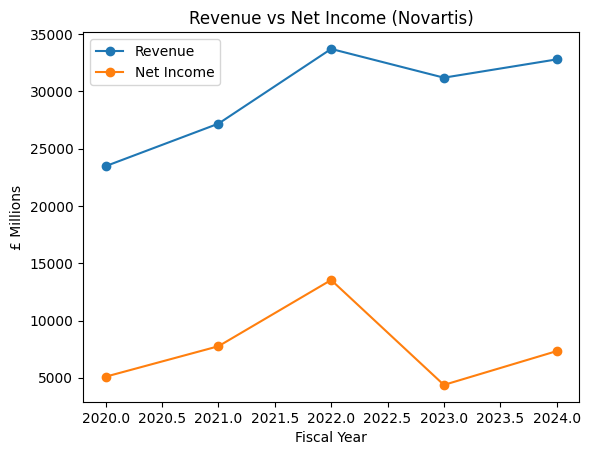

In [61]:
df_company = df[
    (df["company_name"].str.lower() == "bankofmontreal") &
    (df["report_type"].str.lower() == "annual")
]
df_company = df_company.sort_values("fiscal_year")

plt.plot(df_company["fiscal_year"], df_company["revenue_millions"], marker="o", label="Revenue")
plt.plot(df_company["fiscal_year"], df_company["net_income_millions"], marker="o", label="Net Income")
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Revenue vs Net Income (Novartis)")
plt.legend()
plt.show()

# Output 3:
### Revenue and Income for multiple companies and comparisons

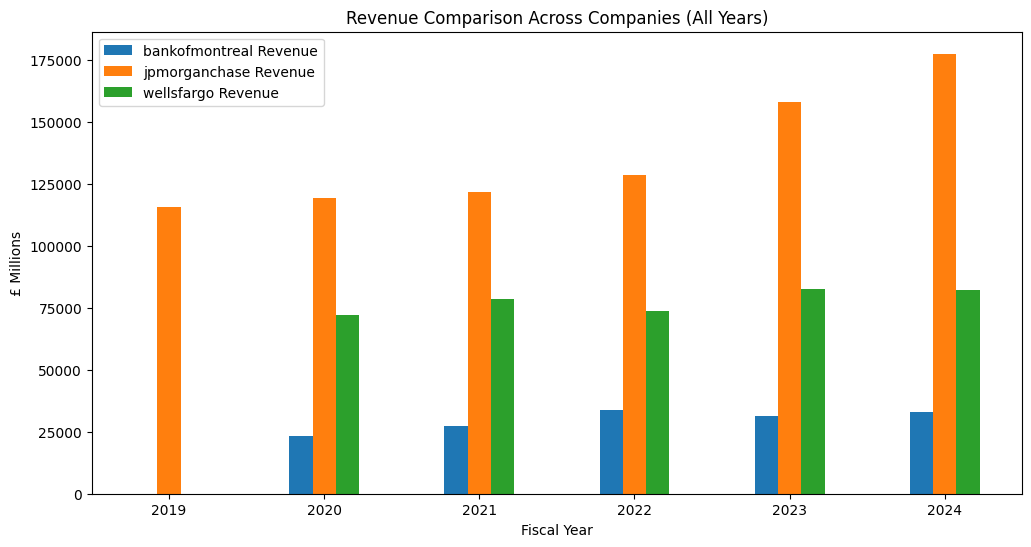

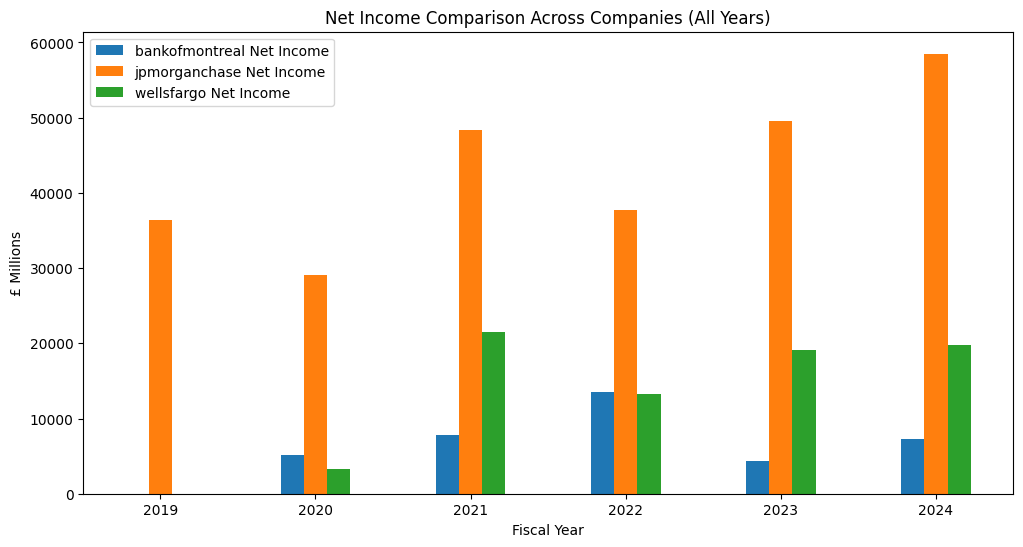

In [55]:

import numpy as np

# Filter only annual reports
df_filtered = df[df["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped = df_filtered.groupby(["company_name", "fiscal_year"])[
    ["revenue_millions", "net_income_millions"]
].sum().reset_index()

# Get unique values
companies = df_grouped["company_name"].unique().tolist()
years = sorted(df_grouped["fiscal_year"].unique())

# Set bar width
bar_width = 0.15
x = np.arange(len(years))  # positions for fiscal years

plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    revenues = [company_data[company_data["fiscal_year"] == y]["revenue_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, revenues, width=bar_width, label=f"{company} Revenue")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)  # Center ticks
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Revenue Comparison Across Companies (All Years)")
plt.legend()
plt.show()

# Repeat for Net Income
plt.figure(figsize=(12,6))
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    net_incomes = [company_data[company_data["fiscal_year"] == y]["net_income_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, net_incomes, width=bar_width, label=f"{company} Net Income")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Net Income Comparison Across Companies (All Years)")
plt.legend()
plt.show()


# 🔮 Revenue Forecasting with AI.FORECAST & TimesFM 2.0


In [56]:
print("🔮 Generating revenue forecasts with TimesFM 2.0...")

forecast_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FORECAST_TABLE_ID}` AS
SELECT
  *
FROM
  AI.FORECAST(
    TABLE `{QUALIFIED_METRICS_TABLE_ID}`,
    data_col => 'revenue_millions',
    timestamp_col => 'fiscal_year_date',
    model => 'TimesFM 2.0',
    id_cols => ['company_name'],
    horizon => 5,
    confidence_level => .95
  )
"""

print("⏳ Forecasting...")
job = client.query(forecast_sql)
job.result()
print("✅ Forecast table created successfully!")

🔮 Generating revenue forecasts with TimesFM 2.0...
⏳ Forecasting...
✅ Forecast table created successfully!


In [ ]:
# import requests
# from google.cloud import bigquery

# PROJECT_ID = "intellitrend-project-dev"   # update if needed
# DATASET_ID = "db_reports_insights_annual_esg"
# TABLE_ID = "all_reports_annual_esg"

# # Step 0: Fetch file list from GitHub
# url = "https://api.github.com/repos/intellitrend-global/google_hackathon_bq_ai/contents/annual_esg_reports"
# response = requests.get(url)
# files = response.json()

# pdf_files = [(f["name"], f["download_url"]) for f in files if f["name"].endswith(".pdf")]

# print("📄 Found PDF files on GitHub:")
# for name, link in pdf_files:
#     print(f"   {name} -> {link}")

# # Step 1: Initialize BigQuery client
# client = bigquery.Client(project=PROJECT_ID)

# # Step 2: Ensure dataset exists (create if not)
# dataset_ref = bigquery.DatasetReference(PROJECT_ID, DATASET_ID)
# try:
#     client.get_dataset(dataset_ref)  # Check if it exists
#     print(f"✅ Dataset {DATASET_ID} already exists")
# except Exception:
#     dataset = bigquery.Dataset(dataset_ref)
#     dataset.location = "US"
#     client.create_dataset(dataset, timeout=30)
#     print(f"📦 Created dataset {DATASET_ID}")

# # Step 3: Define schema
# schema = [
#     bigquery.SchemaField("filename", "STRING"),
#     bigquery.SchemaField("uri", "STRING"),
# ]

# # Step 4: Prepare rows
# rows = [{"filename": name, "uri": link} for name, link in pdf_files]

# # Step 5: Load into BigQuery
# job_config = bigquery.LoadJobConfig(schema=schema, write_disposition="WRITE_TRUNCATE")
# table_ref = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

# job = client.load_table_from_json(rows, table_ref, job_config=job_config)
# job.result()

# print(f"✅ Table {table_ref} created/updated with {len(pdf_files)} GitHub files")
